### Mesoscopic simulation model of SUMO

In [1]:
import os,sys, subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")
import sumolib

### Step 1: create a network from node and edge file

In [55]:
with open('nodes.xml','w') as file:
    file.write('<nodes> \n')
    file.write('<node id="0" x="-200.0" y="0.0" /> \n')
    file.write('<node id="1" x="0.0" y="0.0" /> \n')
    file.write('<node id="2" x="400.0" y="0.0" /> \n')
    file.write('<node id="3" x="400.0" y="100.0" /> \n')
    file.write('<node id="4" x="400.0" y="-100.0" /> \n')
    file.write('<node id="5" x="300.0" y="0.0" /> \n')
    file.write('</nodes>')
    file.close()

In [56]:
with open('edges.xml','w') as file:
    file.write('<edges> \n')
    file.write('<edge from="0" id="origin" to="1" /> \n')
    file.write('<edge from="1" id="center" to="5" /> \n')
    file.write('<edge from="5" id="tls" to="2" /> \n')
    file.write('<edge from="2" id="left" to="3" /> \n')
    file.write('<edge from="2" id="right" to="4" /> \n')
    file.write('<edge from="4" id="right_u" to="2" /> \n')
    file.write('<edge from="3" id="left_d" to="2" /> \n')
    file.write('</edges>')    

In [58]:
os.system('netconvert --node-files=nodes.xml --edge-files=edges.xml --output-file=net.net.xml --no-internal-links \
--tls.set 2 --tls.yellow.time -1 --tls.cycle.time 60')

0

### Step 2: additional files to record data

In [23]:
with open('additional.add.xml','w') as file:
    file.write('<additional> \n')
    file.write('<edgeData id="ed1" file="output/edgeData.xml" freq="300" begin="0" end="7200" excludeEmpty="FALSE" /> \n')
    file.write('<laneData id="la1" file="output/laneData.xml" freq="300" begin="0" end="7200" excludeEmpty="FALSE" /> \n')
    file.write('</additional>')
    

### Step 3: generate demand

In [45]:
with open('routes.rou.xml','w') as file:
    file.write('<routes> \n')
    file.write('<vType carFollowModel="Krauss" accel="2.6" decel="4.5" id="passenger" length="5.0" maxSpeed="50.0" sigma="0.0" /> \n')          
    file.write('<flow id="f1r" type="passenger" begin="0" end="900" number="100" from="origin" to="right"/> \n')
    file.write('<flow id="f1l" type="passenger" begin="0" end="900" number="100" from="origin" to="left"/> \n')
    file.write('<flow id="f2r" type="passenger" begin="900" end="1800" number="200" from="origin" to="right"/> \n')
    file.write('<flow id="f2l" type="passenger" begin="900" end="1800" number="200" from="origin" to="left"/> \n')
    file.write('<flow id="f3r" type="passenger" begin="1800" end="2700" number="400" from="origin" to="right"/> \n')
    file.write('<flow id="f3l" type="passenger" begin="1800" end="2700" number="400" from="origin" to="left"/> \n')
    file.write('<flow id="f4r" type="passenger" begin="2700" end="3600" number="500" from="origin" to="right"/> \n')
    file.write('<flow id="f4l" type="passenger" begin="2700" end="3600" number="500" from="origin" to="left"/> \n')
    file.write('</routes>')

In [114]:
with open('routes.rou.xml','w') as file:
    file.write('<routes> \n')
    file.write('<vType carFollowModel="Krauss" accel="2.6" decel="4.5" id="passenger" length="5.0" maxSpeed="50.0" \
    sigma="0.0" tau="2" minGap="1.5"/> \n')          
    for i in [0,900,1800,2700,3600,4500,5400,6300,7200,8100,9000,9900,10800]:
        file.write('<flow id="fr{}" type="passenger" begin="{}" end="{}" number="{}" from="origin" to="right"/> \n'.\
                   format(i,i,i+900,int(i/900*60+50)))
        file.write('<flow id="fl{}" type="passenger" begin="{}" end="{}" number="{}" from="origin" to="right"/> \n'.\
                   format(i,i,i+900,int(i/900*60+50)))
    file.write('</routes>')

### Step 4: run simulation and plot FD

In [239]:
def runSUMO(meso_edge_length,meso_jam_threshold,tau_ff,tau_fj,tau_jf,tau_jj,tls_penalty):
    os.system('sumo -n net.net.xml -r routes.rou.xml -b 0 -e 12000 -a additional.add.xml -S -Q --mesosim \
--meso-edgelength {} --meso-jam-threshold {} --meso-tauff {} --meso-taufj {} --meso-taujf {} --meso-taujj {} \
--meso-tls-penalty {}'.format(meso_edge_length,meso_jam_threshold,tau_ff,tau_fj,tau_jf,tau_jj,tls_penalty))
    os.system('python "C:/Program Files (x86)/Eclipse/Sumo/tools/xml/xml2csv.py" "output/edgeData.xml" -o output/edge.csv')
    edge_data = pd.read_csv('output/edge.csv',delimiter=";")
    ed = edge_data[['interval_begin','edge_id','edge_density','edge_occupancy','edge_sampledSeconds','edge_speed','edge_traveltime']]
    ed = ed[ed['edge_id']=='center']
    ed['edge_flow']=round(ed['edge_density']*ed['edge_speed']*3.6)
    return ed
    

In [247]:
def plot_fd(edge_data,x_axis,y_axis,xlim,ylim):
    fig,p = plt.subplots()
    p.plot(edge_data[x_axis],edge_data[y_axis],'-o',c="grey",alpha=0.8)
    p.set_xlim(0,xlim)
    p.set_ylim(0,ylim)
    p.set_xlabel('density (veh/km)')
    p.set_ylabel('flow (veh/h)')
    return fig

### Step 5: scenario 

In [235]:
meso_edge_length = 500
meso_jam_threshold = -1
tau_ff = 1.4
tau_fj = 1.4
tau_jf = 1.4
tau_jj = 1.4
tls_penalty = 0.5

In [236]:
sc1=runSUMO(meso_edge_length,meso_jam_threshold,tau_ff,tau_fj,tau_jf,tau_jj,tls_penalty)

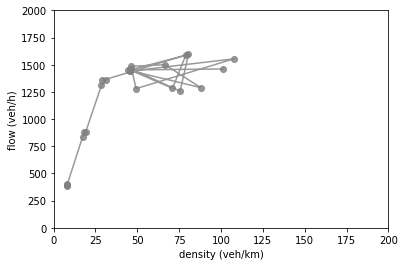

In [249]:
psc1=plot_fd(sc1,'edge_density','edge_flow',200,2000)